<a href="https://colab.research.google.com/github/RyanChen12035/w281_final_galaxy_zoo/blob/main/classifier_pipeline1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# mount Google Drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# copy the filters from ex7
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import urllib
from skimage import feature, io, color
from scipy.cluster.vq import kmeans

np.random.seed(62)
from scipy.cluster.vq import vq

In [5]:
import pandas as pd
csv_file_path = '/content/drive/MyDrive/galaxy_zoo/train_data_reduced.csv'
column_names = ['path', 'index', 'label']
df_train = pd.read_csv(csv_file_path, names=column_names)
df_train = df_train.iloc[1:]
df_train = df_train.reset_index(drop=True)

In [9]:
print(df_train.shape)
df_train.head(5)

(2000, 3)


,path,index,label
0,/content/drive/MyDrive/galaxy_zoo/Train_images...,469264,Class0
1,/content/drive/MyDrive/galaxy_zoo/Train_images...,765243,Class0
2,/content/drive/MyDrive/galaxy_zoo/Train_images...,141731,Class0
3,/content/drive/MyDrive/galaxy_zoo/Train_images...,590463,Class0
4,/content/drive/MyDrive/galaxy_zoo/Train_images...,591026,Class0


In [6]:
import pandas as pd
csv_file_path = '/content/drive/MyDrive/galaxy_zoo/val_data_reduced.csv'
column_names = ['path', 'index', 'label']
df_val = pd.read_csv(csv_file_path, names=column_names)
df_val = df_val.iloc[1:]
df_val = df_val.reset_index(drop=True)

In [10]:
print(df_val.shape)
df_val.head(5)

(250, 3)


,path,index,label
0,/content/drive/MyDrive/galaxy_zoo/Train_images...,217289,Class0
1,/content/drive/MyDrive/galaxy_zoo/Train_images...,339079,Class0
2,/content/drive/MyDrive/galaxy_zoo/Train_images...,150841,Class0
3,/content/drive/MyDrive/galaxy_zoo/Train_images...,398397,Class0
4,/content/drive/MyDrive/galaxy_zoo/Train_images...,201198,Class0


In [11]:
# preprocess and pipeline
from tqdm import tqdm


def grayscale_preprocessing(img):
	if np.max(img) > 1:
		img = img.astype(np.float32) / 255.0
	im_gray = np.mean(img, axis=2)
	return im_gray


def bilateral_preprocessing(img, ksize, sigmX, sigmY):
	bilateral_filtered_image = cv2.bilateralFilter(img, ksize, sigmX, sigmY)
	return bilateral_filtered_image


def high_pass_preprocessing(img, ksize, sig):
	low_pass = cv2.GaussianBlur(img, ksize, 0)
	high_pass = img - low_pass
	return high_pass


def build_codebook(
	preprocessed_features,
	sample_size=1050,
	k=200,
	iters=1,
	save_location="codebook.npy",
):
	"""
	Use k-means clustering to build a codebook of visual words, given a set of SIFT descriptors.
	Args:
					sample_size: number of SIFT descriptors to sample from the training set
	"""
	descriptors_sample = list()
	descriptor_sample = list()
	sample_idx = np.random.randint(0, len(df_train) + 1, sample_size).tolist()
	for i in sample_idx:
		if (
			preprocessed_features[i] is not None
			and len(preprocessed_features[i].shape) == 2
		):
			descriptors_sample.append(preprocessed_features[i])
	descriptor_sample = np.vstack(descriptors_sample)
	codebook, variance = kmeans(descriptor_sample, k, iters)
	np.save(save_location, codebook)
	return codebook


def quantize_and_create_sparse_representation(preprocessed_features, codebook):
	visual_words = []
	frequency_vectors = []
	# for each image descriptor, take every idx and
	for img_descriptors in preprocessed_features:
		if img_descriptors is None:
			visual_words.append(np.zeros(200))
			continue
		img_visual_words, distance = vq(img_descriptors, codebook)
		visual_words.append(img_visual_words)
	for img_visual_words in visual_words:
		# create a frequency vector for each image
		img_frequency_vector = np.zeros(200)
		for word in img_visual_words:
			img_frequency_vector[int(word)] += 1
		frequency_vectors.append(img_frequency_vector)
	frequency_vectors = np.stack(frequency_vectors)
	return frequency_vectors


def sift_bag_of_visual_words(img):
	sift = cv2.SIFT_create()
	image8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
	keypoints, descriptors = sift.detectAndCompute(image8bit, None)
	return descriptors


def sobel_preprocessing(img, ksize):
	sobelx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=ksize)  # Find x and y gradients
	sobely = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=ksize)
	magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
	if np.max(magnitude) == 0:
		return magnitude
	magnitude = magnitude / np.max(magnitude)  # normalize
	return magnitude


def gaussian_blur_preprocessing(img, ksize, sigma):
	blurred_im = cv2.GaussianBlur(img, ksize, sigmaX=sigma[0], sigmaY=sigma[1])
	return blurred_im


def canny_filter(img, high_threshold, low_threshold):
	# ensure the image is normalized to the range [0, 1]
	if np.max(img) != 0:
		img = img / np.max(img)
	# scale the image to the range [0, 255] and convert to 8-bit
	img_8u = np.uint8(img * 255)
	# threshold the image and get the interesting points
	# The high threshold is used to identify the strong edges. Pixels with intensity gradients above this threshold are marked as strong edge pixels.
	# The low threshold is used to identify the non-edges. Pixels with intensity gradients below this threshold are suppressed.
	# By setting the high threshold too low, many pixels might be considered as strong edges, leading to a noisy edge image. Similarly, if the low threshold is set too high, you might miss genuine weak edges that should contribute to the final edge image.

	im_threshold = cv2.Canny(
		image=img_8u, threshold1=low_threshold, threshold2=high_threshold
	)  # Canny Edge
	if np.max(im_threshold) == 0:
		return im_threshold
	im_threshold = im_threshold / np.max(im_threshold)  # normalize
	return im_threshold


def crop_center(img, cropx, cropy):
	y, x = img.shape
	startx = x // 2 - (cropx // 2)
	starty = y // 2 - (cropy // 2)
	return img[starty : starty + cropy, startx : startx + cropx]


def histogram_clipping(img, threshold_value):
	clipped_image = img.copy()
	# before
	# draw_histogram_gray(clipped_image)
	clipped_image[img < threshold_value / 255.0] = 0
	# Normalize the clipped_image to 0-255 for proper histogram visualization
	normalized_clipped_image = cv2.normalize(
		clipped_image,
		None,
		alpha=0,
		beta=255,
		norm_type=cv2.NORM_MINMAX,
		dtype=cv2.CV_8UC1,
	)
	# draw_histogram_gray(clipped_image)
	return normalized_clipped_image


def hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3)):
	block_norm = "L1"  # Block normalization method
	# orientations = 9   # Number of orientation bins
	# pixels_per_cell = (8, 8)  # Size of the cell
	# cells_per_block = (3, 3)  # Size of the block

	# Compute the HOG features
	hog_features, hog_image = feature.hog(
		img_gray,
		orientations=orientations,
		pixels_per_cell=pixels_per_cell,
		cells_per_block=cells_per_block,
		block_norm=block_norm,
		visualize=True,
	)
	return hog_features, hog_image


def preprocess_1(df, codebook=None):
	image_dir = df["path"]  # ignore index
	preprocessed_list = []
	for i, image_path in enumerate(tqdm(image_dir)):
		im = np.array(Image.open(image_path))
		im = grayscale_preprocessing(im)
		im= histogram_clipping(im, 30)
		im = gaussian_blur_preprocessing(
			im, (9, 9), (10, 10)
		)
		im = bilateral_preprocessing(im, 5, 30, 30)
		im = sobel_preprocessing(im, 31)
		im = canny_filter(im, 70, 0)
		im = crop_center(im, 252, 252)
		sift = sift_bag_of_visual_words(im)
		preprocessed_list.append(sift)
	if codebook is None:
		codebook = build_codebook(preprocessed_list)
	frequency_vectors = quantize_and_create_sparse_representation(
		preprocessed_list, codebook
	)
	#max = np.max(frequency_vectors, axis=1)
	#vector_representations_normalized = frequency_vectors / max[:, np.newaxis]
	# im_flattened = im_cropped.flatten(
	return frequency_vectors


def preprocess_2(df):
	image_dir = df["path"]
	preprocessed_list = []

	for i, image_path in enumerate(image_dir):
		im = np.array(Image.open(image_path))

		im_gray = grayscale_preprocessing(im)
		img_histogram_clipping = histogram_clipping(im_gray, 30)
		im_blurred = gaussian_blur_preprocessing(
			img_histogram_clipping, (9, 9), (10, 10)
		)
		im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
		im_cropped = crop_center(im_bilateral, 240, 240)
		hog_feature, hog_image = hog(im_cropped)  # (63504,)
		# im_flattened = hog_feature.flatten()
		preprocessed_list.append(hog_feature)

	df_preprocessed = pd.DataFrame(preprocessed_list)
	return df_preprocessed

In [12]:
preprocessed_features = preprocess_1(df_train)
preprocessed_features.shape

100%|██████████| 2000/2000 [11:26<00:00,  2.91it/s]


In [14]:
preprocessed_features.shape

(2000, 200)

In [18]:
with open("codebook.npy", "rb") as f:
	codebook = np.load(f)
preprocessed_features_val = preprocess_1(df_val, codebook=codebook)
preprocessed_features_val.shape

100%|██████████| 250/250 [00:17<00:00, 13.93it/s]


(250, 200)

In [21]:
# most of examples are zero and others are in the range of 1 to 8
df_processed_1 = pd.DataFrame(preprocessed_features)
df_processed_1_val = pd.DataFrame(preprocessed_features_val)
df_processed_1.iloc[:1].T

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
195,0.0
196,0.0
197,2.0
198,0.0


In [117]:
from sklearn.decomposition import PCA


def pick_top_feature_pca(feature_matrix, top_components):
		# pick up top 100 features by PCA
		pca = PCA(n_components=150)
		pca.fit(feature_matrix)
		principal_components = pca.transform(feature_matrix)
		top_components_matrix = principal_components[:, :top_components]

		plt.figure(figsize=(8, 4))
		plt.plot(np.cumsum(pca.explained_variance_ratio_))
		plt.xlabel("Number of PCA components")
		plt.ylabel("Cumulative explained variance")
		plt.title("Explained Variance vs Number of PCA Components")
		plt.grid(True)
		plt.show()
		# Extract the top n components
		return top_components_matrix, pca

# use the pca embedding from train and process the val and test
def pick_top_feature_pca_val_test(pca_train, feature_matrix, top_components: int):
  principal_components = pca_train.transform(feature_matrix)
  top_components_matrix = principal_components[:, :top_components]
  return top_components_matrix

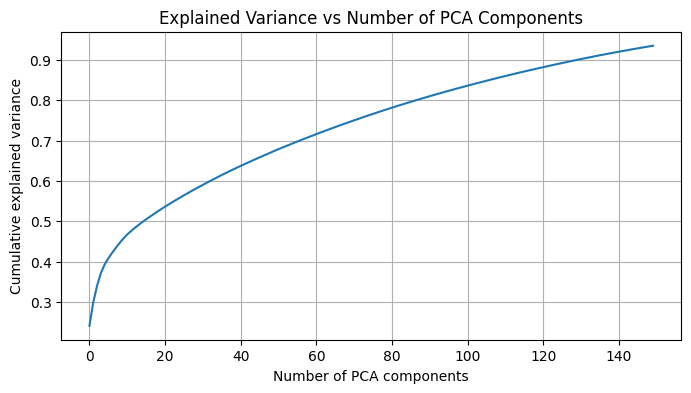

In [118]:
top_100_feature_pca_1, pca_train = pick_top_feature_pca(df_processed_1.values, 80)
top_100_feature_pca_1_val = pick_top_feature_pca_val_test(pca_train, df_processed_1_val.values, 80)

df_top_100_feature_pca_1 = pd.DataFrame(top_100_feature_pca_1)
df_top_100_feature_pca_1_val = pd.DataFrame(top_100_feature_pca_1_val)

In [82]:
# feature normarlization since we only pick up top 200. z score normalization

from sklearn.preprocessing import StandardScaler
def feature_normalization(df_feature):
		scaler = StandardScaler()
		normalized_features = scaler.fit_transform(df_feature.values)
		df_normalized = pd.DataFrame(normalized_features, columns=df_feature.columns)
		return df_normalized

In [83]:
df_top_100_feature_pca_1_normalized = feature_normalization(df_top_100_feature_pca_1)
df_top_100_feature_pca_1_val_normalized = feature_normalization(df_top_100_feature_pca_1_val)

In [92]:
df_top_100_feature_pca_1_normalized.head(5)

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,-0.306100,-0.956927,1.287563,0.208415,-0.366978,-1.829315,0.387593,-0.903033,-1.381709,-0.764559,...,0.648615,-0.613649,-0.215276,0.079371,-0.916250,-0.964353,1.013094,-0.295578,-0.537840,-0.907680
1,-0.362519,0.598243,0.371100,-1.488921,1.562331,0.005081,0.607748,-1.139858,-0.812520,-0.848639,...,-0.122802,1.131467,0.614612,-0.301254,0.926419,1.004349,-0.502583,1.389108,0.073834,-1.002231
2,-0.569709,-0.654586,1.499118,-0.066395,0.274547,0.340151,-1.442234,-0.765767,-0.661458,0.067131,...,-0.463859,-0.077308,0.300299,0.765273,0.030476,-0.243440,-1.016077,0.098838,-1.105841,0.135304
3,-0.559239,0.012031,0.358485,-0.881718,0.960099,-1.284037,-0.514039,-0.559478,-0.631201,0.899491,...,-0.872463,0.192156,0.462705,0.821588,-0.120484,0.189314,-0.100591,0.074635,0.002648,1.527301
4,-0.023734,-0.340865,-0.069711,-0.944559,-0.877361,-1.618679,0.378539,1.159744,-2.250789,-0.266520,...,0.548395,-0.729635,0.728396,-0.071677,1.216142,0.538783,1.528913,0.426079,-0.250937,2.127522


In [94]:
df_top_100_feature_pca_1_normalized.values

array([[-0.30610038, -0.95692662,  1.28756273, ..., -0.29557764,
        -0.5378396 , -0.90767999],
       [-0.36251872,  0.59824268,  0.37109986, ...,  1.3891075 ,
         0.07383358, -1.00223069],
       [-0.56970895, -0.65458648,  1.49911809, ...,  0.09883843,
        -1.10584067,  0.13530375],
       ...,
       [-0.67091696,  0.14500187, -0.11520633, ..., -0.49502959,
        -0.41568773, -0.00720971],
       [-0.4460992 ,  0.46764733, -0.69075566, ..., -1.46978894,
        -0.94682865, -0.19263521],
       [ 0.47899244,  4.36303034, -1.27390001, ...,  0.93030848,
        -2.0412817 , -0.67459758]])

In [85]:
df_train_reduced_preprocessed_pca_1 = pd.concat(
	[
		df_train,
		df_top_100_feature_pca_1_normalized,
	],
	axis=1,
)

df_train_reduced_preprocessed_pca_1_val = pd.concat(
	[
		df_val,
		df_top_100_feature_pca_1_val_normalized,
	],
	axis=1,
)
print(
	df_train_reduced_preprocessed_pca_1.shape,
	df_train_reduced_preprocessed_pca_1_val.shape
)

(2000, 83) (250, 83)


In [86]:
df_train_reduced_preprocessed_pca_1.to_csv(
	"/content/drive/MyDrive/galaxy_zoo/df_train_reduced_preprocessed_pca_1", index=False
)
df_train_reduced_preprocessed_pca_1_val.to_csv(
	"/content/drive/MyDrive/galaxy_zoo/df_train_reduced_preprocessed_pca_1_val", index=False
)

SVM

In [124]:
from sklearn.metrics import accuracy_score
Y_train = df_train['label']
max = np.max(preprocessed_features, axis=1)
vector_representations_normalized = preprocessed_features / max[:, np.newaxis]
X_train = vector_representations_normalized
# X_train = df_top_100_feature_pca_1_normalized.values

# z score would cause overfitting and pca would just deteriorate the performance

In [125]:
Y_val = df_val['label']
max_val = np.max(preprocessed_features_val, axis=1)
vector_representations_normalized_val = preprocessed_features_val / max_val[:, np.newaxis]
x_val = vector_representations_normalized_val
# x_val = df_top_100_feature_pca_1_val_normalized.values

In [126]:
# use svm
from sklearn.svm import SVC
model = SVC(kernel='rbf', C=0.5, gamma=0.1, random_state=42)
model.fit(X_train, Y_train)

SVC(C=0.5, gamma=0.1, random_state=42)

In [127]:
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(Y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

Training Accuracy: 0.7135


In [128]:
y_val_pred = model.predict(x_val)
val_accuracy = accuracy_score(Y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.512


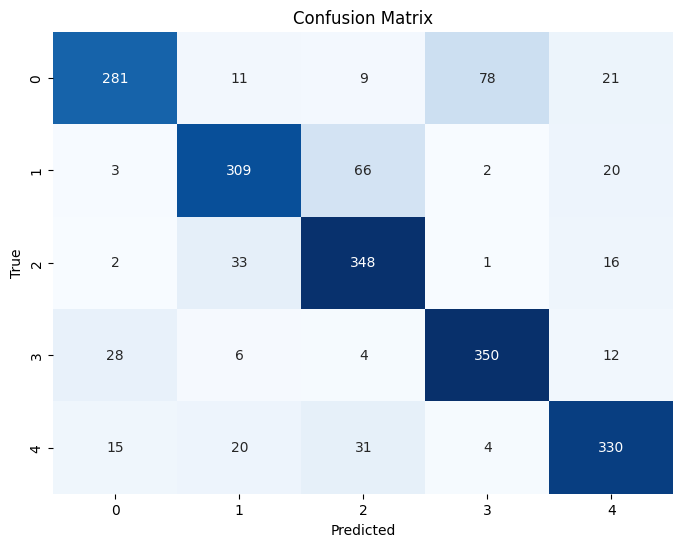

In [59]:
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(Y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="g", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

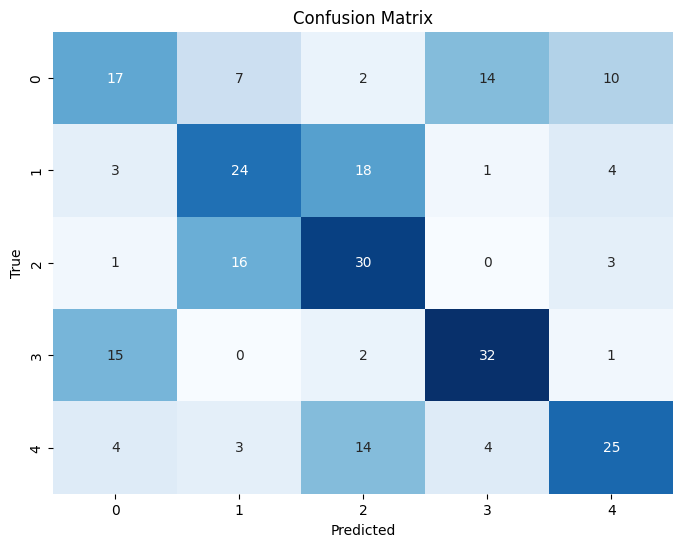

In [63]:
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(Y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="g", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

LDA + linear regression

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

Y_train = df_train['label']
max = np.max(preprocessed_features, axis=1)
vector_representations_normalized = preprocessed_features / max[:, np.newaxis]
X_train = vector_representations_normalized

Y_val = df_val['label']
max_val = np.max(preprocessed_features_val, axis=1)
vector_representations_normalized_val = preprocessed_features_val / max_val[:, np.newaxis]
x_val = vector_representations_normalized_val

# LDA to reduce the dimension to number of class - 1
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train, Y_train)

# logistic regression as the classifer in the space of LDA space
classifier = LogisticRegression()
classifier.fit(X_train_lda, Y_train)
y_train_pred = classifier.predict(X_train_lda)

# Logistic Regression with L1 regularization
# [0.001, 0.01, 0.1, 1]
classifier_l1 = LogisticRegression(penalty='l1', C=1 , solver='liblinear')
classifier_l1.fit(X_train_lda, Y_train)


# transform the test data to the LDA feature space and make predictions
X_val_lda = lda.transform(x_val)
y_val_pred = classifier.predict(X_val_lda)

# evaluate the Model
accuracy = accuracy_score(Y_val, y_val_pred)
print("validation accuracy:", accuracy)
train_accuracy = accuracy_score(Y_train, classifier.predict(X_train_lda))
print("Training Accuracy:", train_accuracy)
train_accuracy_l1 = accuracy_score(Y_train, classifier_l1.predict(X_train_lda))
print("Training Accuracy with L1 Regularization:", train_accuracy_l1)

validation accuracy: 0.452
Training Accuracy: 0.63
Training Accuracy with L1 Regularization: 0.625


z score would cause overfitting and pca would just deteriorate the performance, SVM (non-linear) > LDA + regression.